# Navigation #
This is the main interface file corresponding to the Navigation exercise. Here, all of the plots and checkpoints are generated.

Contents:
* [Imports](#first-bullet)
* [Set up environment](#second-bullet)
* [Set up training functions](#third-bullet)
* [Set up playing functions](#fourth-bullet)
* [Results](#fifth-bullet)
* [Comparative results](#sixth-bullet)
* [Basic Conclusion](#seventh-bullet)

## 1 - Imports <a class="anchor" id="first-bullet"></a>

In this subsection, we import the relevant source code and UnityEngine. We also import auxiliarry imports which are useful for us.

In [1]:
import src as navigation
import numpy as np
from src.agent import deque, torch
import matplotlib.pyplot as plt
import os

In [2]:
import sys
DRL_LOCATION = os.environ['_DRL_LOCATION_']
sys.path.insert(0,DRL_LOCATION)
from unityagents import UnityEnvironment
BANANA_LOCATION = os.environ['_BANANA_LOCATION_']

## 2 - Set up environement <a class="anchor" id="second-bullet"></a>

Here we set up the environment from UnityEngine. However, we wrap this around our bespoke environment wrapper in order to make 'env' behave more like the OpenAI environments.

In [3]:
_env_ = UnityEnvironment(file_name=BANANA_LOCATION)
env = navigation.Environment(_env_)

## 3 - Set up training functions <a class="anchor" id="third-bullet"></a>

In this section we set up the relevant functions for training

In [4]:
def dqn(env, agent, folder, is_train_mode = True, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, \
        eps_decay=0.8, stop_at_goal = True):
    """Deep Q-Learning. Returns the scores and the number of episodes required to solve the environment if stop_at_goal
    is true. If stop_at_goal is false, will return scores for n_episodes without stopping.
    
    Params
    ======
        env (env): Environment
        agent (Agent): The agent
        folder (string): the folder string name to deposit results
        is_train_mode (boolean):If train mode is on or not.
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        n_episodes (int) : Number of episodes
        max_t (int) : Maximum number of time steps considered
        stop_at_goal (boolean) : If true, will stop when environment is solved, else will continue for n_episodes
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    solved_in = None
    for i_episode in range(1, n_episodes+1):
        state = env.reset(is_train_mode=is_train_mode)
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if stop_at_goal:
            if np.mean(scores_window)>=13.0:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
                torch.save(agent.qnetwork_local.state_dict(), "results/"+folder+"/checkpoint.pth")
                solved_in = i_episode-100
                break
        elif i_episode==2000:
            torch.save(agent.qnetwork_local.state_dict(), "results/"+folder+"/checkpoint_final.pth")
    return scores, solved_in

In [5]:
def moving_average(arr):
    """
    Computes the moving average over all past numbers in an array. Returns an array of moving averages.
    
    Params
    ======
        arr (array) : An array
    """
    m = [0]*len(arr)
    for i in range(0,len(arr)):
        if i == 0:
            m[i] = arr[i]
        else:
            N = i
            m[i] = N*m[i-1]/(N+1)+arr[i]/(N+1)
    return m

def create_folder(hidden_layers, drop_p, with_dueling, isDDQN):
    """
    Creates and returns a string corresponding to a folder name used for storage in the results folder.
    
    Params
    ======
        hidden_layers (array): Hidden number of nodes in each layer
        drop_p (float [0-1]) : Probability of dropping nodes (implementation of dropout)
        with_dueling (boolean) : If true, network is dueling network, otherwise false.
        isDDQN (boolean) : If true, double dqn in implemented, otherwise false.
    """
    x = hidden_layers
    folder = [str(i) for i in x]
    seperator = '_'
    folder = seperator.join(folder) + '_'
    folder+=str(int(10*drop_p))+'_'
    folder+=str(with_dueling)+'_'
    folder+=str(isDDQN)
    if not os.path.exists("results/"+folder):
        os.makedirs("results/"+folder)
        
    return folder

In [6]:
def train_model(hidden_layers, drop_p, with_dueling, isDDQN, n_episodes=2000, \
                max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.8, stop_at_goal = True):
    """
    Performs the training for the model given various parametrisations. Returns the scores,
    moving sverage of the scores, the folder name and the number of episodes required to solve the
    environment if stop_at_goal is True else none.
    
    Params
    ======
        hidden_layers (array): Hidden number of nodes in each layer
        drop_p (float [0-1]) : Probability of dropping nodes (implementation of dropout)
        with_dueling (boolean) : If true, network is dueling network, otherwise false.
        isDDQN (boolean) : If true, double dqn in implemented, otherwise false.
        n_episodes (int) : Number of episodes
        max_t (int) : Maximum number of time steps considered
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        stop_at_goal (boolean) : If true, will stop when environment is solved, else will continue for n_episodes
    """

    agent = navigation.Agent( state_size=37, action_size=4, seed=0, hidden_layers = hidden_layers, \
                             drop_p = drop_p, with_dueling = with_dueling)

    folder = create_folder(hidden_layers, drop_p, with_dueling, isDDQN)

    scores, solved_in = dqn(env, agent, folder, True,n_episodes, max_t, eps_start, eps_end, eps_decay,stop_at_goal)
    
    ma_scores = moving_average(scores)
    return scores, ma_scores, folder, solved_in

In [7]:
def plot(scores, ma_scores, folder):
    ax = plt.subplots(figsize=(20, 10))
    plt.plot(np.arange(len(scores)), scores,label = 'Scores')
    plt.plot(np.arange(len(scores)), ma_scores, label = 'Moving average scores')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.legend(loc='upper left')
    plt.savefig("results/"+folder+"/plot.png")
    plt.show()

## 4 - Set up playing environment<a class="anchor" id="fourth-bullet"></a>

This sets up the playing environment once the training has occured. 

In [8]:
def play(env, hidden_layers, drop_p, with_dueling, isDDQN, max_t = 1000):
    model = navigation.QNetwork(state_size = 37, action_size = 4, seed = 0,  hidden_layers  = hidden_layers, drop_p = 0, dueling = with_dueling)
    
    x = hidden_layers
    folder = [str(i) for i in x]
    seperator = '_'
    folder = seperator.join(folder) + '_'
    folder+=str(int(10*drop_p))+'_'
    folder+=str(with_dueling)+'_'
    folder+=str(isDDQN)
    weights = "results/"+folder+"/checkpoint.pth"
    
    model.load_state_dict(torch.load(weights))
    model.eval()
    model = model.double()
    state = env.reset(is_train_mode=False)
    state = torch.from_numpy(state).double()
    score = 0
    for t in range(max_t):
        with torch.no_grad():
            action = model(state.double())
            action = np.argmax(action.numpy())
            next_state, reward, done = env.step(action)
            state = next_state
            state = torch.from_numpy(state).double()
            score += reward
        if done:
            break 
    return score

## 5 - Results<a class="anchor" id="fifth-bullet"></a>

This is the main section where the results a computed and displayed. We consider four main improveement methodologies reolving around the double DQN and dueling DQN. Namely, we consider:

        - No improvement methods
        - Double DQN
        - Duelling DQN
        - Both Double DQN and Dueling DQN

We produce plots for each of these cases for the number of episodes reuqired to solve the environment.

At the end we produce a comparative plot of all four methods without stopping when the environment is solved, instead continuing for 2000 episodes.

In [9]:
# Increase font size of plt plots for aesthetic convenience.
plt.rcParams.update({'font.size': 22})

### 5a  - No improvement methods

iteration 0
Episode 100	Average Score: 4.20
Episode 200	Average Score: 8.26
Episode 300	Average Score: 11.36
Episode 380	Average Score: 13.00
Environment solved in 280 episodes!	Average Score: 13.00
iteration 1
Episode 100	Average Score: 4.95
Episode 200	Average Score: 6.74
Episode 300	Average Score: 11.77
Episode 342	Average Score: 13.03
Environment solved in 242 episodes!	Average Score: 13.03
iteration 2
Episode 100	Average Score: 3.96
Episode 200	Average Score: 9.56
Episode 300	Average Score: 10.89
Episode 356	Average Score: 13.04
Environment solved in 256 episodes!	Average Score: 13.04
iteration 3
Episode 100	Average Score: 3.98
Episode 200	Average Score: 8.13
Episode 300	Average Score: 12.15
Episode 325	Average Score: 13.05
Environment solved in 225 episodes!	Average Score: 13.05
iteration 4
Episode 100	Average Score: 1.00
Episode 200	Average Score: 6.30
Episode 300	Average Score: 9.74
Episode 400	Average Score: 12.82
Episode 409	Average Score: 13.10
Environment solved in 309 epis

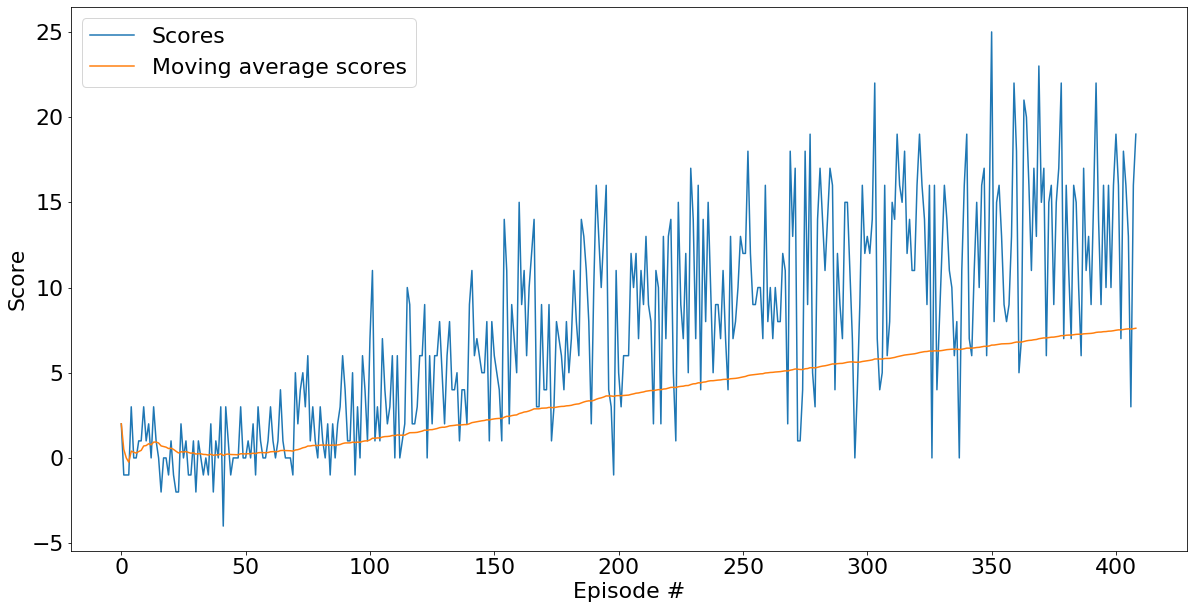

In [10]:
hidden_layers = [64,128,64]
drop_p = 0.00
with_dueling = False
isDDQN = False
model_results = []
for i in range(0,5):
    print('iteration ' + str(i))
    scores, ma_scores, folder, solved_in = train_model(hidden_layers, drop_p, with_dueling, isDDQN,n_episodes=2000, \
                    max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.95)
    model_results.append([scores, ma_scores, folder, solved_in])
print('Average number of episodes problem is solved in: ',int(np.mean(np.array(model_results)[:,3])))
data = model_results[np.argmax(np.array(model_results)[:,3])]
scores, ma_scores, folder = data[0],data[1],data[2]
print('Plotting scores for smallest number of episodes')
plot(scores, ma_scores, folder)

### 5b  - Duelling DQN

iteration 0
Episode 100	Average Score: 2.04
Episode 200	Average Score: 5.64
Episode 300	Average Score: 10.36
Episode 400	Average Score: 11.88
Episode 455	Average Score: 13.01
Environment solved in 355 episodes!	Average Score: 13.01
iteration 1
Episode 100	Average Score: 4.44
Episode 200	Average Score: 9.06
Episode 300	Average Score: 11.66
Episode 356	Average Score: 13.02
Environment solved in 256 episodes!	Average Score: 13.02
iteration 2
Episode 100	Average Score: 3.41
Episode 200	Average Score: 7.41
Episode 300	Average Score: 11.99
Episode 324	Average Score: 13.07
Environment solved in 224 episodes!	Average Score: 13.07
iteration 3
Episode 100	Average Score: 1.60
Episode 200	Average Score: 6.48
Episode 300	Average Score: 8.18
Episode 400	Average Score: 12.32
Episode 425	Average Score: 13.14
Environment solved in 325 episodes!	Average Score: 13.14
iteration 4
Episode 100	Average Score: 2.70
Episode 200	Average Score: 8.71
Episode 300	Average Score: 10.28
Episode 358	Average Score: 13.

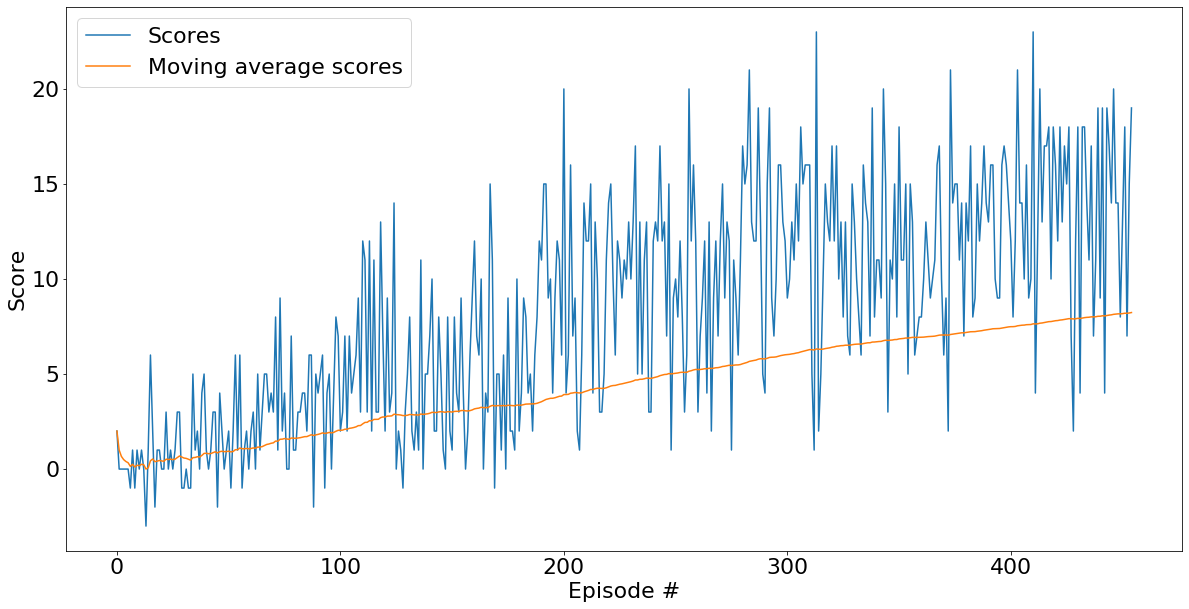

In [11]:
hidden_layers = [64,128,64]
drop_p = 0.00
with_dueling = True
isDDQN = False
model_results = []
for i in range(0,5):
    print('iteration ' + str(i))
    scores, ma_scores, folder, solved_in = train_model(hidden_layers, drop_p, with_dueling, isDDQN,n_episodes=2000, \
                    max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.95)
    model_results.append([scores, ma_scores, folder, solved_in])
print('Average number of episodes problem is solved in: ',int(np.mean(np.array(model_results)[:,3])))
data = model_results[np.argmax(np.array(model_results)[:,3])]
scores, ma_scores, folder = data[0],data[1],data[2]
print('Plotting scores for smallest number of episodes')
plot(scores, ma_scores, folder)

### 5c  - Double DQN

iteration 0
Episode 100	Average Score: 2.44
Episode 200	Average Score: 6.83
Episode 300	Average Score: 10.81
Episode 376	Average Score: 13.02
Environment solved in 276 episodes!	Average Score: 13.02
iteration 1
Episode 100	Average Score: 5.40
Episode 200	Average Score: 8.67
Episode 300	Average Score: 12.30
Episode 341	Average Score: 13.01
Environment solved in 241 episodes!	Average Score: 13.01
iteration 2
Episode 100	Average Score: 5.13
Episode 200	Average Score: 8.79
Episode 300	Average Score: 12.49
Episode 319	Average Score: 13.01
Environment solved in 219 episodes!	Average Score: 13.01
iteration 3
Episode 100	Average Score: 2.96
Episode 200	Average Score: 7.24
Episode 300	Average Score: 11.54
Episode 354	Average Score: 13.03
Environment solved in 254 episodes!	Average Score: 13.03
iteration 4
Episode 100	Average Score: 4.25
Episode 200	Average Score: 6.94
Episode 300	Average Score: 11.52
Episode 357	Average Score: 13.01
Environment solved in 257 episodes!	Average Score: 13.01
Avera

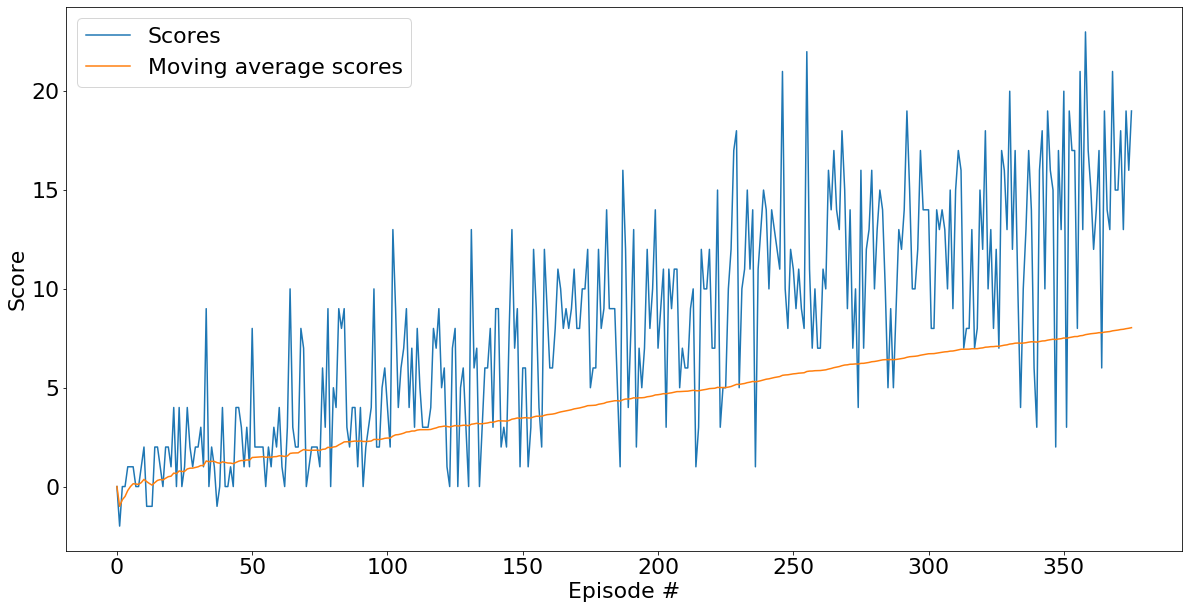

In [12]:
hidden_layers = [64,128,64]
drop_p = 0.00
with_dueling = False
isDDQN = True
model_results = []
for i in range(0,5):
    print('iteration ' + str(i))
    scores, ma_scores, folder, solved_in = train_model(hidden_layers, drop_p, with_dueling, isDDQN,n_episodes=2000, \
                    max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.95)
    model_results.append([scores, ma_scores, folder, solved_in])
print('Average number of episodes problem is solved in: ',int(np.mean(np.array(model_results)[:,3])))
data = model_results[np.argmax(np.array(model_results)[:,3])]
scores, ma_scores, folder = data[0],data[1],data[2]
print('Plotting scores for smallest number of episodes')
plot(scores, ma_scores, folder)

### 5d  - Double and Duelling DQN

iteration 0
Episode 100	Average Score: 3.87
Episode 200	Average Score: 8.81
Episode 300	Average Score: 11.71
Episode 390	Average Score: 13.07
Environment solved in 290 episodes!	Average Score: 13.07
iteration 1
Episode 100	Average Score: 3.43
Episode 200	Average Score: 7.62
Episode 300	Average Score: 10.02
Episode 389	Average Score: 13.03
Environment solved in 289 episodes!	Average Score: 13.03
iteration 2
Episode 100	Average Score: 2.14
Episode 200	Average Score: 7.28
Episode 300	Average Score: 11.58
Episode 340	Average Score: 13.04
Environment solved in 240 episodes!	Average Score: 13.04
iteration 3
Episode 100	Average Score: 3.54
Episode 200	Average Score: 7.53
Episode 300	Average Score: 11.10
Episode 359	Average Score: 13.00
Environment solved in 259 episodes!	Average Score: 13.00
iteration 4
Episode 100	Average Score: 2.54
Episode 200	Average Score: 9.15
Episode 300	Average Score: 11.40
Episode 352	Average Score: 13.08
Environment solved in 252 episodes!	Average Score: 13.08
Avera

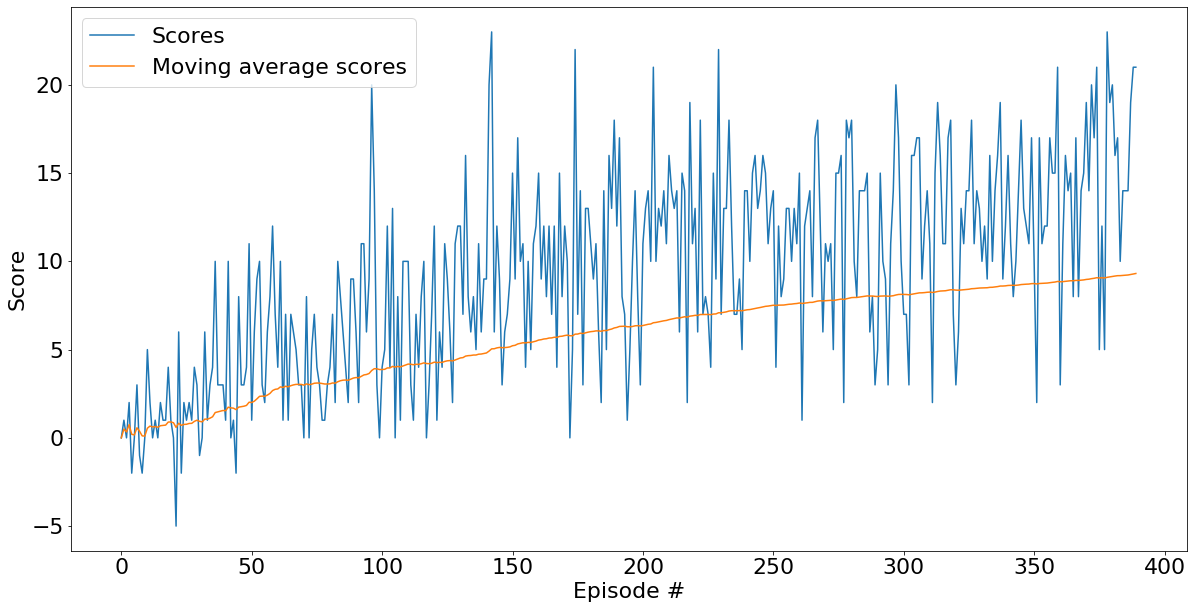

In [13]:
hidden_layers = [64,128,64]
drop_p = 0.00
with_dueling = True
isDDQN = True
model_results = []
for i in range(0,5):
    print('iteration ' + str(i))
    scores, ma_scores, folder, solved_in = train_model(hidden_layers, drop_p, with_dueling, isDDQN,n_episodes=2000, \
                    max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.95)
    model_results.append([scores, ma_scores, folder, solved_in])
print('Average number of episodes problem is solved in: ',int(np.mean(np.array(model_results)[:,3])))
data = model_results[np.argmax(np.array(model_results)[:,3])]
scores, ma_scores, folder = data[0],data[1],data[2]
print('Plotting scores for smallest number of episodes')
plot(scores, ma_scores, folder)

## 6 - Comparative results<a class="anchor" id="sixth-bullet"></a>

We now consider a long term (number of episode = 2000) comparative study of the algorithm improvements studied. We first create a dictionary, save it as a pickle file and produce the plot to used for analysis.

In [9]:
models = {}

hidden_layers = [64,128,64]
drop_p = 0.00
with_dueling = False
isDDQN = False
scores, ma_scores, folder = train_model(hidden_layers, drop_p, with_dueling, isDDQN,n_episodes=2000, \
                max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.95, stop_at_goal = False)
models['without_dueling_without_double']=[scores,ma_scores]

Episode 100	Average Score: 4.20
Episode 200	Average Score: 8.41
Episode 300	Average Score: 10.63
Episode 400	Average Score: 13.84
Episode 500	Average Score: 15.56
Episode 600	Average Score: 15.81
Episode 700	Average Score: 16.09
Episode 800	Average Score: 15.32
Episode 900	Average Score: 14.78
Episode 1000	Average Score: 14.67
Episode 1100	Average Score: 14.66
Episode 1200	Average Score: 15.14
Episode 1300	Average Score: 14.99
Episode 1400	Average Score: 15.22
Episode 1500	Average Score: 14.46
Episode 1600	Average Score: 14.30
Episode 1700	Average Score: 15.00
Episode 1800	Average Score: 14.78
Episode 1900	Average Score: 15.28
Episode 2000	Average Score: 14.62


In [10]:
with_dueling = True
isDDQN = False
scores, ma_scores, folder = train_model(hidden_layers, drop_p, with_dueling, isDDQN,n_episodes=2000, \
                max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.95, stop_at_goal = False)
models['with_dueling_without_double']=[scores,ma_scores]

Episode 100	Average Score: 3.63
Episode 200	Average Score: 9.04
Episode 300	Average Score: 12.74
Episode 400	Average Score: 13.49
Episode 500	Average Score: 14.92
Episode 600	Average Score: 16.38
Episode 700	Average Score: 16.15
Episode 800	Average Score: 16.54
Episode 900	Average Score: 16.45
Episode 1000	Average Score: 16.32
Episode 1100	Average Score: 16.04
Episode 1200	Average Score: 15.79
Episode 1300	Average Score: 16.43
Episode 1400	Average Score: 15.82
Episode 1500	Average Score: 15.84
Episode 1600	Average Score: 16.11
Episode 1700	Average Score: 15.24
Episode 1800	Average Score: 15.62
Episode 1900	Average Score: 14.37
Episode 2000	Average Score: 15.46


In [11]:
with_dueling = False
isDDQN = True
scores, ma_scores, folder = train_model(hidden_layers, drop_p, with_dueling, isDDQN,n_episodes=2000, \
                max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.95, stop_at_goal = False)
models['without_dueling_with_double']=[scores,ma_scores]

Episode 100	Average Score: 3.93
Episode 200	Average Score: 7.32
Episode 300	Average Score: 10.82
Episode 400	Average Score: 13.42
Episode 500	Average Score: 14.29
Episode 600	Average Score: 16.13
Episode 700	Average Score: 15.28
Episode 800	Average Score: 16.08
Episode 900	Average Score: 15.66
Episode 1000	Average Score: 16.36
Episode 1100	Average Score: 15.43
Episode 1200	Average Score: 15.94
Episode 1300	Average Score: 15.96
Episode 1400	Average Score: 15.30
Episode 1500	Average Score: 14.45
Episode 1600	Average Score: 14.67
Episode 1700	Average Score: 14.36
Episode 1800	Average Score: 15.59
Episode 1900	Average Score: 15.53
Episode 2000	Average Score: 15.19


In [12]:
with_dueling = True
isDDQN = True
scores, ma_scores, folder = train_model(hidden_layers, drop_p, with_dueling, isDDQN,n_episodes=2000, \
                max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.95, stop_at_goal = False)
models['with_dueling_with_double']=[scores,ma_scores]

Episode 100	Average Score: 3.68
Episode 200	Average Score: 7.97
Episode 300	Average Score: 11.62
Episode 400	Average Score: 14.12
Episode 500	Average Score: 15.71
Episode 600	Average Score: 16.00
Episode 700	Average Score: 15.17
Episode 800	Average Score: 15.66
Episode 900	Average Score: 15.14
Episode 1000	Average Score: 15.97
Episode 1100	Average Score: 16.25
Episode 1200	Average Score: 15.54
Episode 1300	Average Score: 14.50
Episode 1400	Average Score: 15.12
Episode 1500	Average Score: 15.70
Episode 1600	Average Score: 15.08
Episode 1700	Average Score: 15.20
Episode 1800	Average Score: 15.62
Episode 1900	Average Score: 15.99
Episode 2000	Average Score: 15.66


In [16]:
import pickle

In [15]:
with open('alltraining.pickle', 'wb') as handle:
    pickle.dump(models, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [17]:
with open('alltraining.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [21]:
b.keys()

dict_keys(['without_dueling_without_double', 'with_dueling_without_double', 'without_dueling_with_double', 'with_dueling_with_double'])

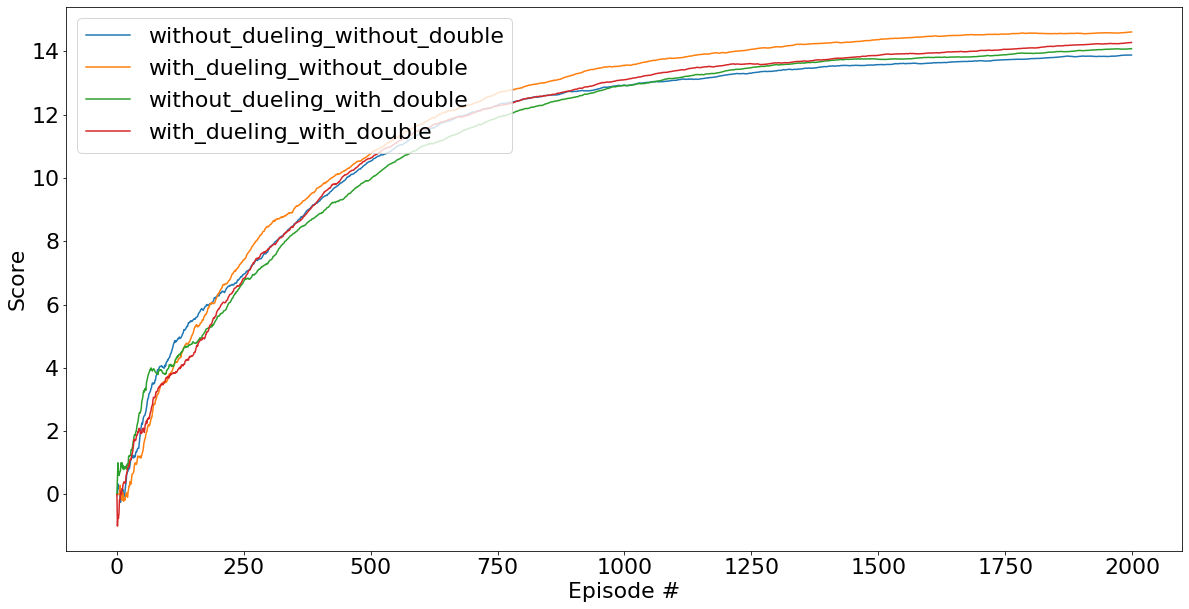

In [24]:
ax = plt.subplots(figsize=(20, 10))
for k,v in b.items():
    scores = v[1]
    label = k
    plt.plot(np.arange(len(scores)), scores, label = label)
plt.legend(loc='upper left')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('comparative.png')

In [31]:
#Play implemented to generate gif in README.
play(env,[64,128,64], 0 ,True, False)
env.close()

11.0

## 7 - Basic conclusion<a class="anchor" id="seventh-bullet"></a>

The basic conclusion following the results in section 5a - 5d is as follows:

| Improvement method | Average # episodes | Smallest # episodes |
| --- | --- | --- |
| None (Replay) | 262 | 225 |
| Double DQN | 258 | 224 |
| Dueling DQN | 249 | 219 |
| Double DQN and Dueling DQN | 266 | 240 |

Thus the best performing improvement methodology as a result of this study is with **duelling DQN** since it produces both the **lowest average amount** of epsiodes to solve the environment, but also the **lowest minimum number of episodes**.

From the comparative study in section 6, we see the the double DQN performs better for about 50 episodes, whilst being finally caught up by the no methodolody improvement algorithm. Ultimately, the **delling DQN** maintains its stable long term performance over the other algorithms considered.

We thus conclude that the winning algorithm in the **duelling DQN!**.